In [1]:
import torch
import os
from PIL import Image, ImageDraw, ImageFont
import random
import shutil
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

print(f"CUDA is available: {torch.cuda.is_available()}")
print(f"Amount of CUDA devices available: {torch.cuda.device_count()}")
print(f"Index of current CUDA device: {torch.cuda.current_device()}")
print(f"Name of current CUDA device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
print(f"Amount of CPU cores available: {os.cpu_count()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cores = os.cpu_count()

CUDA is available: True
Amount of CUDA devices available: 1
Index of current CUDA device: 0
Name of current CUDA device: Tesla V100-SXM3-32GB
Amount of CPU cores available: 96


In [2]:
def add_date_stamp_to_images(input_dir, output_dir):
    try:
        shutil.rmtree(output_dir)
        print(f"Directory '{output_dir}' has been removed successfully.")
    except OSError as error:
        print(error)

    # Create directories for clean and noisy (stamped) images
    clean_dir = os.path.join(output_dir, "clean")
    stamped_dir = os.path.join(output_dir, "stamped")
    os.makedirs(clean_dir, exist_ok=True)
    os.makedirs(stamped_dir, exist_ok=True)

    for subdir in ['training', 'validation', 'evaluation']:
        input_subdir = os.path.join(input_dir, subdir)
        clean_subdir = os.path.join(clean_dir, subdir)
        stamped_subdir = os.path.join(stamped_dir, subdir)
        os.makedirs(clean_subdir, exist_ok=True)
        os.makedirs(stamped_subdir, exist_ok=True)

        i = 0

        for image_name in os.listdir(input_subdir):
            if i >= 1000:
                break
                # break or pass to limit or not

            # Load image
            image_path = os.path.join(input_subdir, image_name)
            image = Image.open(image_path)

            # Save clean version
            clean_output_path = os.path.join(clean_subdir, image_name)
            image.save(clean_output_path)

            # Add date stamp to a copy
            draw = ImageDraw.Draw(image)
            date_text = f"{random.choice(months)} {random.randint(1, 28)}, 2024"
            font = ImageFont.load_default(32)  # Use default font
            text_width = draw.textlength(date_text, font=font)
            x, y = image.width - text_width - 10, image.height - 50
            draw.text((x, y), date_text, fill="white", font=font)

            # Save stamped version
            stamped_output_path = os.path.join(stamped_subdir, image_name)
            image.save(stamped_output_path)

            if i % 500 == 0:
                print(f"Date stamped: {stamped_output_path}")
            i += 1

    print(f"Paired dataset created at '{output_dir}'")


months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November',
          'December']

add_date_stamp_to_images("dataset", "dataset_with_paired_images")

Directory 'dataset_with_paired_images' has been removed successfully.
Date stamped: dataset_with_paired_images/stamped/training/2_394.jpg
Date stamped: dataset_with_paired_images/stamped/training/9_321.jpg
Date stamped: dataset_with_paired_images/stamped/validation/2_394.jpg
Date stamped: dataset_with_paired_images/stamped/validation/2_297.jpg
Date stamped: dataset_with_paired_images/stamped/evaluation/2_394.jpg
Date stamped: dataset_with_paired_images/stamped/evaluation/5_8.jpg
Paired dataset created at 'dataset_with_paired_images'


In [3]:
class PreloadedDateStampedDataset(Dataset):
    def __init__(self, stamped_dir, clean_dir, transform):

        self.stamped_images = []
        self.clean_images = []

        file_count = sum([len(files) for _, _, files in os.walk("dataset_with_paired_images/stamped/")])
        print(f"Total files in dataset_with_paired_images/stamped/: {file_count}")

        file_count = sum([len(files) for _, _, files in os.walk("dataset_with_paired_images/clean/")])
        print(f"Total files in dataset_with_paired_images/clean/: {file_count}")

        i = 0

        # Apply transformations and load stamped images
        for stamped_file in sorted(os.listdir(stamped_dir)):
            stamped_path = os.path.join(stamped_dir, stamped_file)
            stamped_image = Image.open(stamped_path).convert("RGB")
            if transform:
                stamped_image = transform(stamped_image)
            self.stamped_images.append(stamped_image)
            i += 1
            if i % 1000 == 0:
                print(f"Loaded {i} stamped images into memory.")

        i = 0
        # Apply transformations and load clean images
        for clean_file in sorted(os.listdir(clean_dir)):
            clean_path = os.path.join(clean_dir, clean_file)
            clean_image = Image.open(clean_path).convert("RGB")
            if transform:
                clean_image = transform(clean_image)
            self.clean_images.append(clean_image)
            i += 1
            if i % 1000 == 0:
                print(f"Loaded {i} clean images into memory.")

        # Ensure equal number of stamped and clean images
        assert len(self.stamped_images) == len(self.clean_images), "Mismatch in paired dataset size"

    def __len__(self):
        return len(self.stamped_images)

    def __getitem__(self, idx):
        # Preprocessed images are already in memory
        stamped_image = self.stamped_images[idx]
        clean_image = self.clean_images[idx]
        return stamped_image, clean_image


# Transformations for input images
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize to [-1, 1]
])

# Initialize DataLoaders
train_loader = DataLoader(
    PreloadedDateStampedDataset(
        stamped_dir='dataset_with_paired_images/stamped/training',
        clean_dir='dataset_with_paired_images/clean/training',
        transform=transform
    ),
    batch_size=64, shuffle=True, num_workers=0, pin_memory=True
)

val_loader = DataLoader(
    PreloadedDateStampedDataset(
        stamped_dir='dataset_with_paired_images/stamped/validation',
        clean_dir='dataset_with_paired_images/clean/validation',
        transform=transform
    ),
    batch_size=64, shuffle=False, num_workers=0, pin_memory=True
)

eval_loader = DataLoader(
    PreloadedDateStampedDataset(
        stamped_dir='dataset_with_paired_images/stamped/evaluation',
        clean_dir='dataset_with_paired_images/clean/evaluation',
        transform=transform
    ),
    batch_size=64, shuffle=False, num_workers=0, pin_memory=True
)

for stamped_batch, clean_batch in train_loader:
    print(stamped_batch.shape, clean_batch.shape)
    break

Total files in dataset_with_paired_images/stamped/: 3000
Total files in dataset_with_paired_images/clean/: 3000
Loaded 1000 stamped images into memory.
Loaded 1000 clean images into memory.
Total files in dataset_with_paired_images/stamped/: 3000
Total files in dataset_with_paired_images/clean/: 3000
Loaded 1000 stamped images into memory.
Loaded 1000 clean images into memory.
Total files in dataset_with_paired_images/stamped/: 3000
Total files in dataset_with_paired_images/clean/: 3000
Loaded 1000 stamped images into memory.
Loaded 1000 clean images into memory.
torch.Size([64, 3, 448, 448]) torch.Size([64, 3, 448, 448])


In [4]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # Encoder layers
        self.enc1 = self.encoder_block(3, 64, batch_norm=False)
        self.enc2 = self.encoder_block(64, 128)
        self.enc3 = self.encoder_block(128, 256)
        self.enc4 = self.encoder_block(256, 512)
        self.enc5 = self.encoder_block(512, 512)

        # Decoder layers
        self.dec4 = self.decoder_block(512, 512)
        self.dec3 = self.decoder_block(512, 256)
        self.dec2 = self.decoder_block(256, 128)
        self.dec1 = self.decoder_block(128, 64)

        # Final output layer
        self.final = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def encoder_block(self, in_channels, out_channels, batch_norm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        ]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        return nn.Sequential(*layers)

    def decoder_block(self, in_channels, out_channels, dropout=False):
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)
        ]
        if dropout:
            layers.append(nn.Dropout(0.5))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)  # Downsample 1
        e2 = self.enc2(e1)  # Downsample 2
        e3 = self.enc3(e2)  # Downsample 3
        e4 = self.enc4(e3)  # Downsample 4
        e5 = self.enc5(e4)  # Bottleneck

        # Decoder with skip connections
        d4 = self.dec4(e5) + e4  # Upsample 1
        d3 = self.dec3(d4) + e3  # Upsample 2
        d2 = self.dec2(d3) + e2  # Upsample 3
        d1 = self.dec1(d2) + e1  # Upsample 4

        return self.final(d1)


In [5]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super(PatchGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()  # Output is a probability
        )

    def forward(self, x):
        return self.model(x)


In [6]:
# Define weight initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, mean=1.0, std=0.02)
        nn.init.constant_(m.bias, 0)


# Initialize models
generator = UNetGenerator().to(device)
discriminator = PatchGANDiscriminator().to(device)

# Apply weights initialization
generator.apply(weights_init)
discriminator.apply(weights_init)


PatchGANDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (12): Sigmoid()
  )
)

In [19]:
# Loss functions
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.00005, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999))

num_epochs = 200

patience = 3
best_val_loss = float("inf")
early_stop_counter = 0

In [20]:
for epoch in range(num_epochs):
    # Training phase
    generator.train()
    discriminator.train()
    for stamped_images, clean_images in train_loader:
        stamped_images, clean_images = stamped_images.to(device), clean_images.to(device)

        # Generate fake images
        fake_images = generator(stamped_images)

        # Train Discriminator
        discriminator.zero_grad()
        real_preds = discriminator(clean_images)
        fake_preds = discriminator(fake_images.detach())
        real_labels = torch.ones_like(real_preds).to(device)
        fake_labels = torch.zeros_like(fake_preds).to(device)

        real_loss = bce_loss(real_preds, real_labels)
        fake_loss = bce_loss(fake_preds, fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        generator.zero_grad()
        fake_preds = discriminator(fake_images)
        real_labels = torch.ones_like(fake_preds).to(device)  # Real labels for generator
        adv_loss = bce_loss(fake_preds, real_labels)  # Adversarial loss
        recon_loss = l1_loss(fake_images, clean_images)  # Reconstruction loss
        g_loss = adv_loss + 100 * recon_loss  # Combine losses
        g_loss.backward()
        g_optimizer.step()

    # Validation phase
    generator.eval()  # Set generator to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for val_stamped_images, val_clean_images in val_loader:
            val_stamped_images, val_clean_images = val_stamped_images.to(device), val_clean_images.to(device)

            val_fake_images = generator(val_stamped_images)
            val_fake_preds = discriminator(val_fake_images)
            val_real_labels = torch.ones_like(val_fake_preds).to(device)

            val_adv_loss = bce_loss(val_fake_preds, val_real_labels)  # Adversarial loss
            val_recon_loss = l1_loss(val_fake_images, val_clean_images)  # Reconstruction loss
            val_loss += val_adv_loss.item() + 100 * val_recon_loss.item()

    val_loss /= len(val_loader)  # Average validation loss

    print(
        f"Epoch [{epoch + 1}/{num_epochs}] - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0

        # Save the best generator model
        torch.save(generator.state_dict(), "best_generator.pth")
        torch.save(discriminator.state_dict(), "best_discriminator.pth")
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

Epoch [1/200] - D Loss: 0.3306, G Loss: 7.1241, Val Loss: 5.2545
Epoch [2/200] - D Loss: 0.3260, G Loss: 5.4472, Val Loss: 5.3564
Early stopping counter: 1/3
Epoch [3/200] - D Loss: 0.5314, G Loss: 6.3269, Val Loss: 5.9572
Early stopping counter: 2/3
Epoch [4/200] - D Loss: 0.5170, G Loss: 5.7748, Val Loss: 5.3155
Early stopping counter: 3/3
Early stopping triggered. Training stopped.


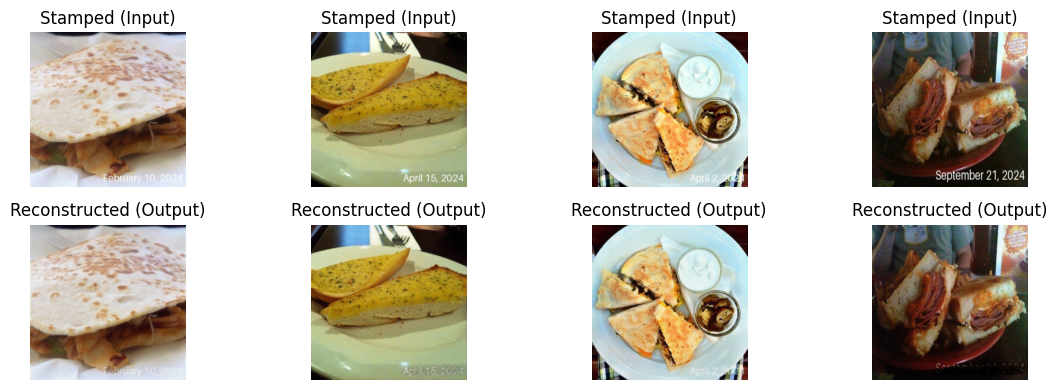

In [21]:
def show_images(input_images, reconstructed, n=4):
    plt.figure(figsize=(12, 4))  # Adjust figure size
    for i in range(n):
        # Stamped (Input) images
        plt.subplot(2, n, i + 1)
        input_img = input_images[i].permute(1, 2, 0).cpu().numpy()  # CHW -> HWC
        input_img = (input_img + 1) / 2  # Normalize from [-1, 1] to [0, 1]
        input_img = np.clip(input_img, 0, 1)  # Ensure pixel values are in [0, 1]
        plt.imshow(input_img)
        plt.axis('off')
        plt.title("Stamped (Input)")

        # Reconstructed (Generated) images
        plt.subplot(2, n, i + 1 + n)
        reconstructed_img = reconstructed[i].permute(1, 2, 0).cpu().numpy()  # CHW -> HWC
        reconstructed_img = (reconstructed_img + 1) / 2  # Normalize from [-1, 1] to [0, 1]
        reconstructed_img = np.clip(reconstructed_img, 0, 1)  # Ensure pixel values are in [0, 1]
        plt.imshow(reconstructed_img)
        plt.axis('off')
        plt.title("Reconstructed (Output)")

    plt.tight_layout()
    plt.show()


# Evaluate the generator on the evaluation dataset
stamped_images, reconstructed_images = [], []

# Load the best generator model
generator.load_state_dict(torch.load("best_generator.pth"))
generator.eval()

with torch.no_grad():
    for stamped, clean in eval_loader:
        stamped = stamped.to(device, non_blocking=True)
        outputs = generator(stamped)  # Use generator to produce reconstructed images
        stamped_images.extend(stamped.cpu())
        reconstructed_images.extend(outputs.cpu())
        if len(stamped_images) >= 4:  # Limit to 4 examples
            break

# Visualize
show_images(stamped_images, reconstructed_images)